### Исследование данных датасетов

![1](./_PPG_Signal.png)

# Real-World PPG dataset

Photoplethysmograph (PPG) is a physiological signal used to describe the volumetric change of blood flow in peripherals with heart beats. A hardware configuration is employed to capture PPG signals from a number of persons using an IoT sensor. This dataset contains PPG signals from 35 healthy persons , with 50 to 60 PPG signal for each one. Each PPG signal contains 300 samples (6 seconds recording) with 50 sample/second sampling rate. The dataset is split into two files: one for training the ANN which contains 1374 PPG signal (about 66% of complete dataset), and the other file to test the ANN which contains 700 PPG signal (about 34% of complete dataset).

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, find_peaks
import heartpy as hp

from pathlib import Path

Возьмём файл test, т.к. он банально меньше (700 записей против 1400)

In [32]:
f_path = Path.cwd() / 'DATASETS' / 'Real-World PPG dataset' / './test8.xlsx'

df = pd.read_excel(f_path, header=None)

# Удаляем пустые ячйки
df.drop([300, 301, 303], inplace=True)
df = df.rename({302: "sample_no", 304: "patient_no"})

# 615-й отрезок времени почему-то везде пустой, его тоже удаляем
df.drop(615, axis=1)

df

0        1        2        3        4        5        6    \
0           35115.0  34856.0  35398.0  34462.0  35153.0  35457.0  33382.0   
1           35119.0  34866.0  35413.0  34484.0  35171.0  35367.0  33246.0   
2           35113.0  34884.0  35415.0  34500.0  35193.0  35210.0  33025.0   
3           35107.0  34895.0  35349.0  34506.0  35200.0  35129.0  32896.0   
4           35107.0  34913.0  35210.0  34443.0  35221.0  35082.0  32844.0   
...             ...      ...      ...      ...      ...      ...      ...   
297         34941.0  34923.0  35512.0  34338.0  35336.0  35043.0  32909.0   
298         34949.0  34814.0  35410.0  34368.0  35349.0  35058.0  32933.0   
299         34967.0  34697.0  35251.0  34381.0  35361.0  35067.0  32968.0   
sample_no       1.0      2.0      3.0      4.0      5.0      6.0      7.0   
patient_no      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

                7        8        9    ...      690      691      692  \
0           34538.0  35012.0  34985.0  ...  29496.0  29361.0  29285.0   
1           34554.0  35040.0  35015.0  ...  29505.0  29360.0  29283.0   
2           34564.0  35064.0  35031.0  ...  29518.0  29357.0  29278.0   
3           34575.0  35090.0  35051.0  ...  29528.0  29361.0  29278.0   
4           34581.0  35103.0  35072.0  ...  29540.0  29369.0  29284.0   
...             ...      ...      ...  ...      ...      ...      ...   
297         34581.0  34954.0  34734.0  ...  29741.0  29358.0  29467.0   
298         34602.0  34976.0  34751.0  ...  29749.0  29305.0  29475.0   
299         34624.0  34995.0  34765.0  ...  29755.0  29265.0  29479.0   
sample_no       8.0      9.0     10.0  ...    691.0    692.0    693.0   
patient_no      1.0      1.0      1.0  ...     35.0     35.0     35.0   

                693      694      695      696      697      698      699  
0           29654.0  29577.0  29106.0  28819.0  29448.0  29461.0  29329.0  
1           29657.0  29589.0  29097.0  28819.0  29441.0  29470.0  29337.0  
2           29666.0  29594.0  29098.0  28813.0  29451.0  29480.0  29338.0  
3           29675.0  29599.0  29113.0  28808.0  29463.0  29495.0  29346.0  
4           29688.0  29609.0  29129.0  28810.0  29475.0  29505.0  29352.0  
...             ...      ...      ...      ...      ...      ...      ...  
297         29749.0  29652.0  29349.0  28814.0  29587.0  29587.0  29442.0  
298         29755.0  29658.0  29355.0  28823.0  29592.0  29592.0  29450.0  
299         29764.0  29670.0  29358.0  28824.0  29600.0  29603.0  29459.0  
sample_no     694.0    695.0    696.0    697.0    698.0    699.0    700.0  
patient_no     35.0     35.0     35.0     35.0     35.0     35.0     35.0  

[302 rows x 700 columns]

Сырые значения сигнала изначально перевёрнуты, нормализуем данные чтобы это исправить

In [33]:
df_maxs = df.iloc[0:300].max()
df_mins = df.iloc[0:300].min()

df_data_norm = (df.iloc[0:300] - df_mins) / (df_maxs - df_mins)

df.iloc[0:300] = (1 - df_data_norm)

Теперь просто визуализируем некоторый образец PPG, найдём для него R-зубцы и RR-интервалы

In [44]:
sample_rate = 50

time = np.arange(0, 6, 1 / sample_rate)

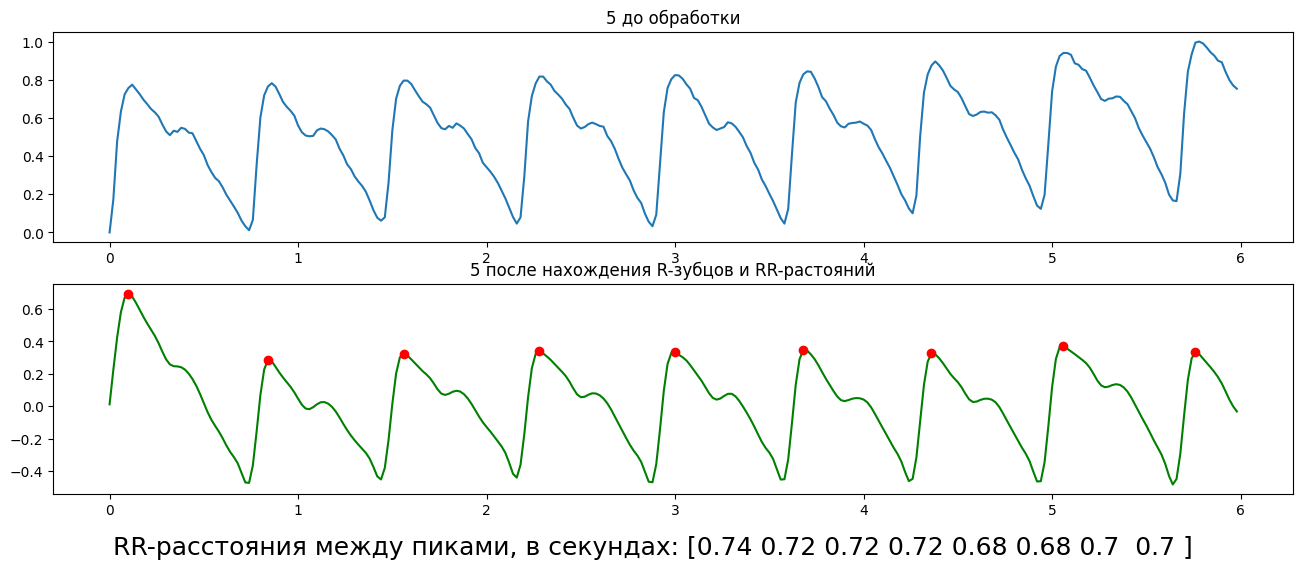

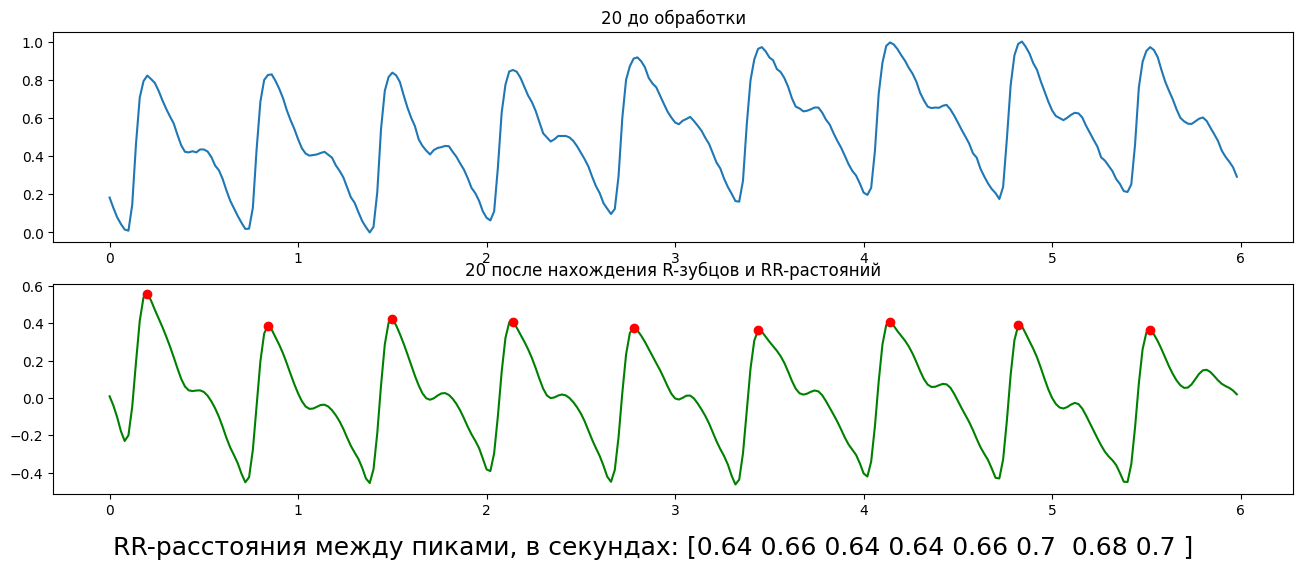

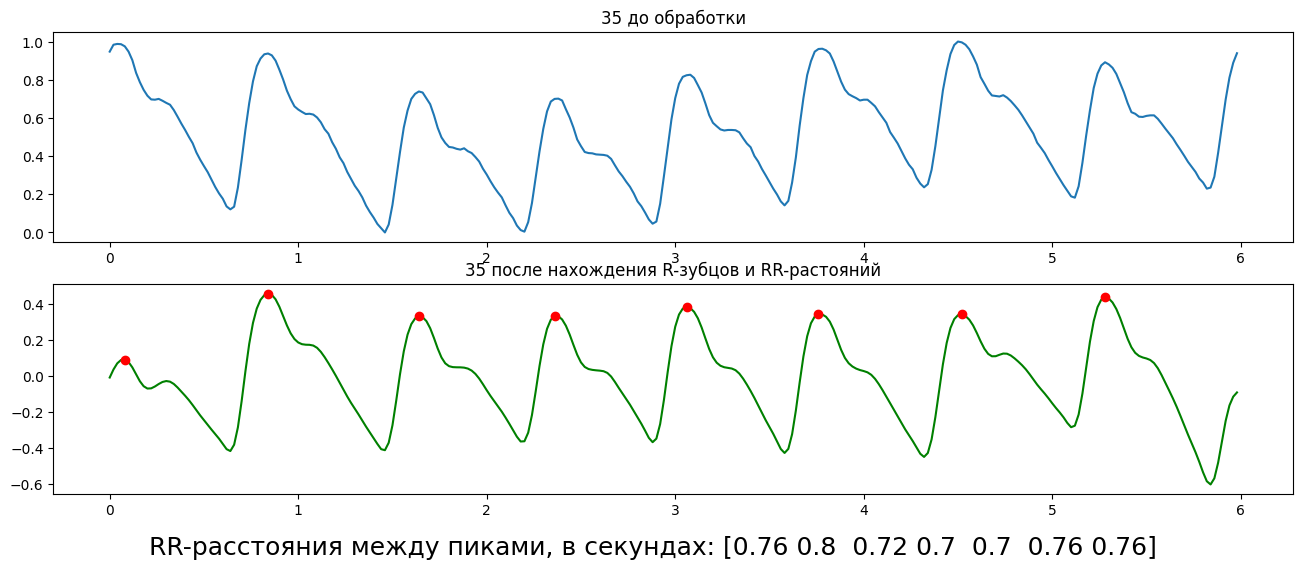

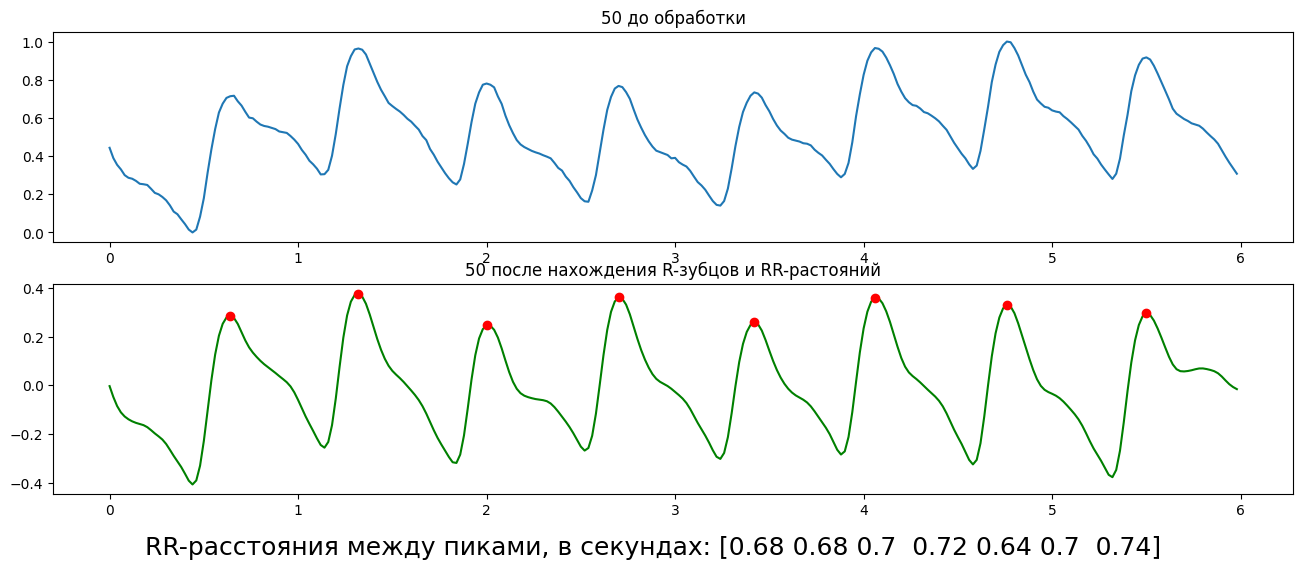

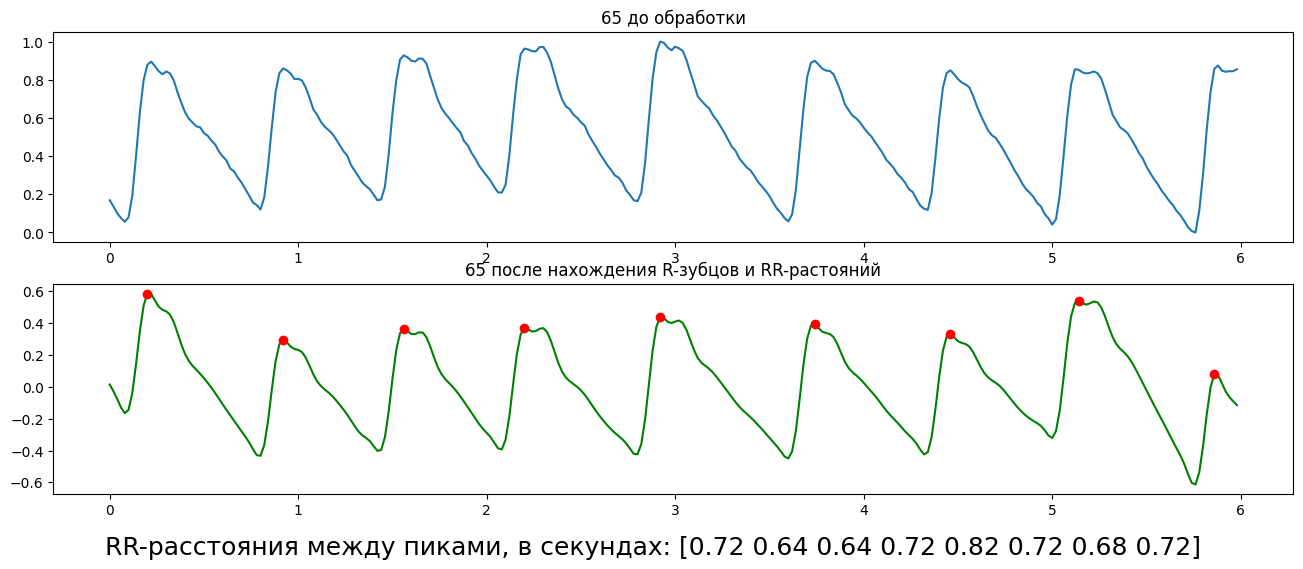

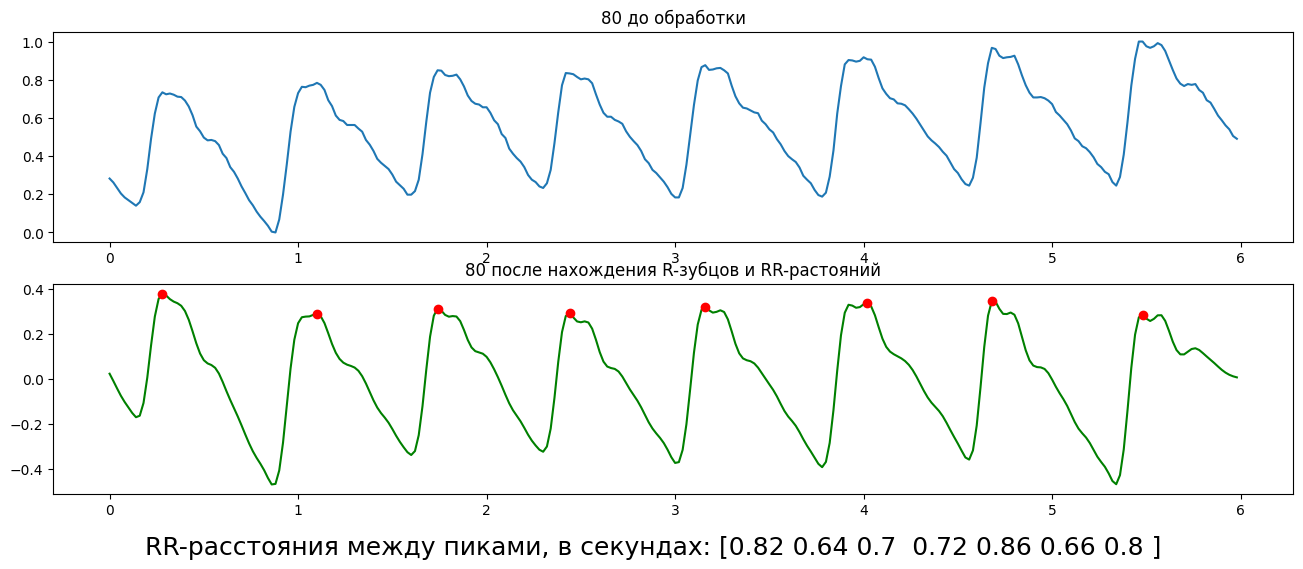

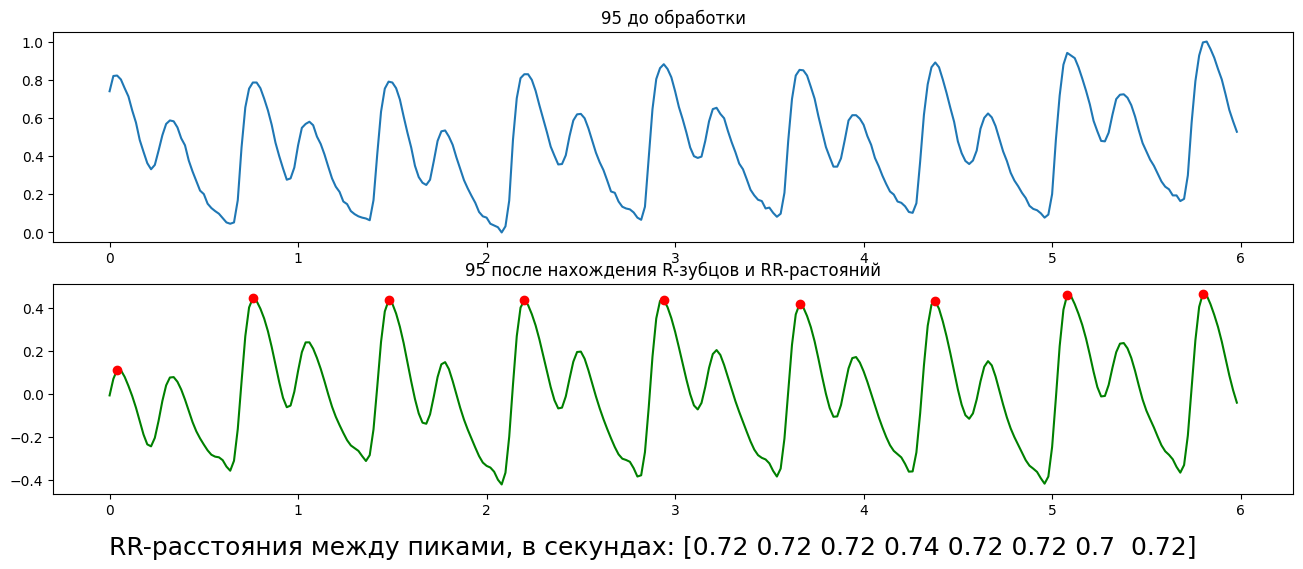

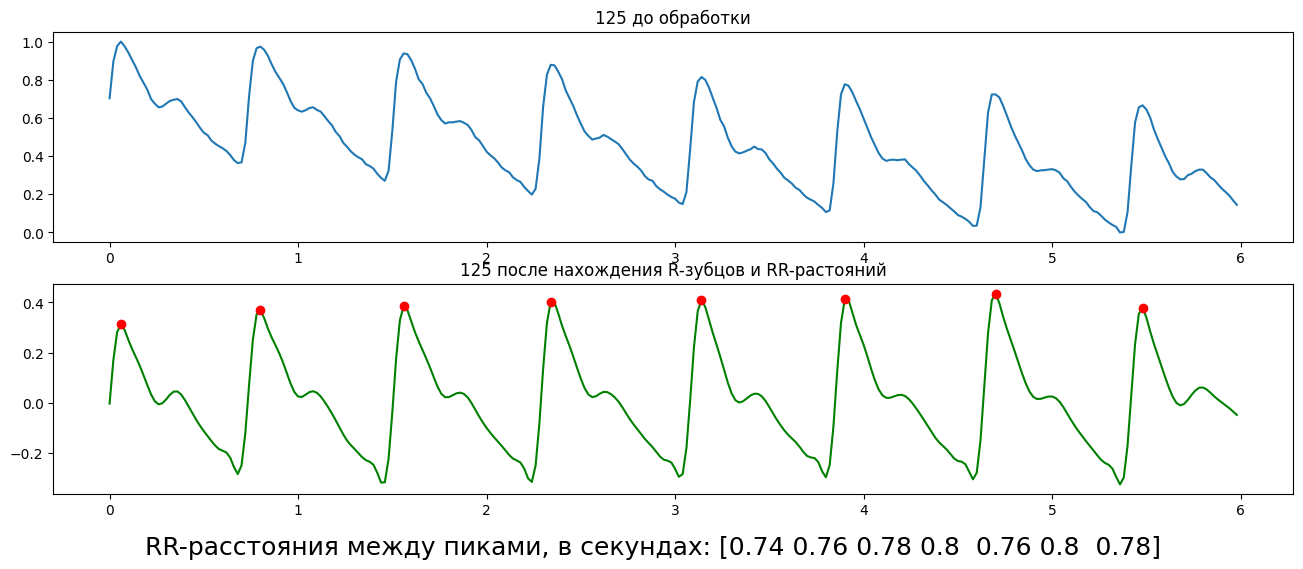

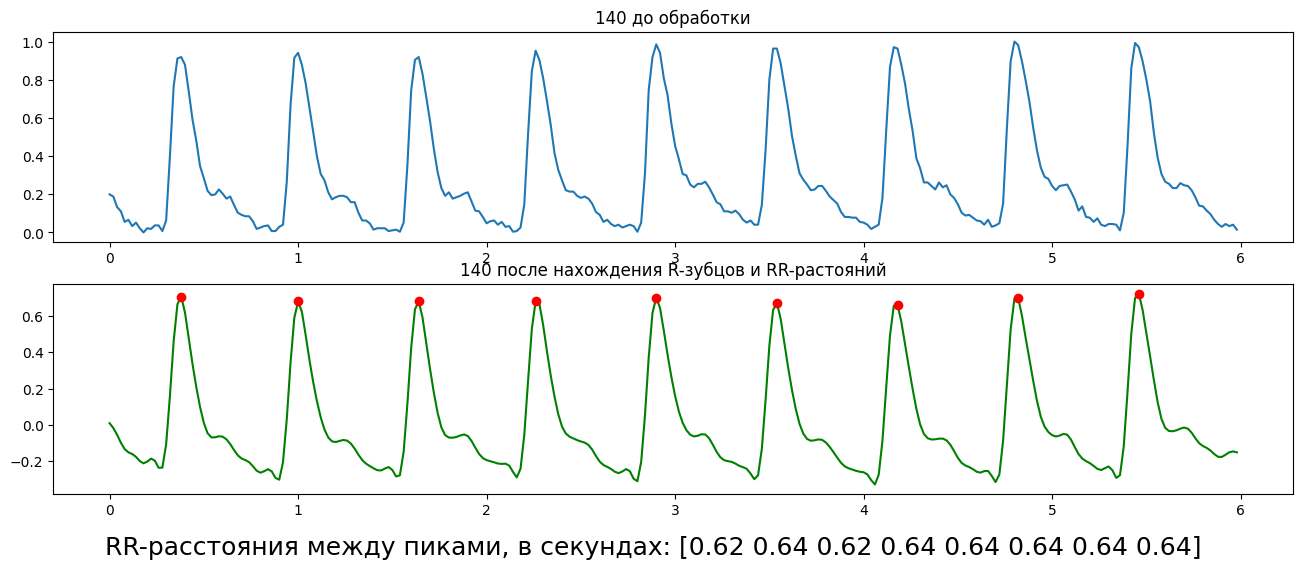

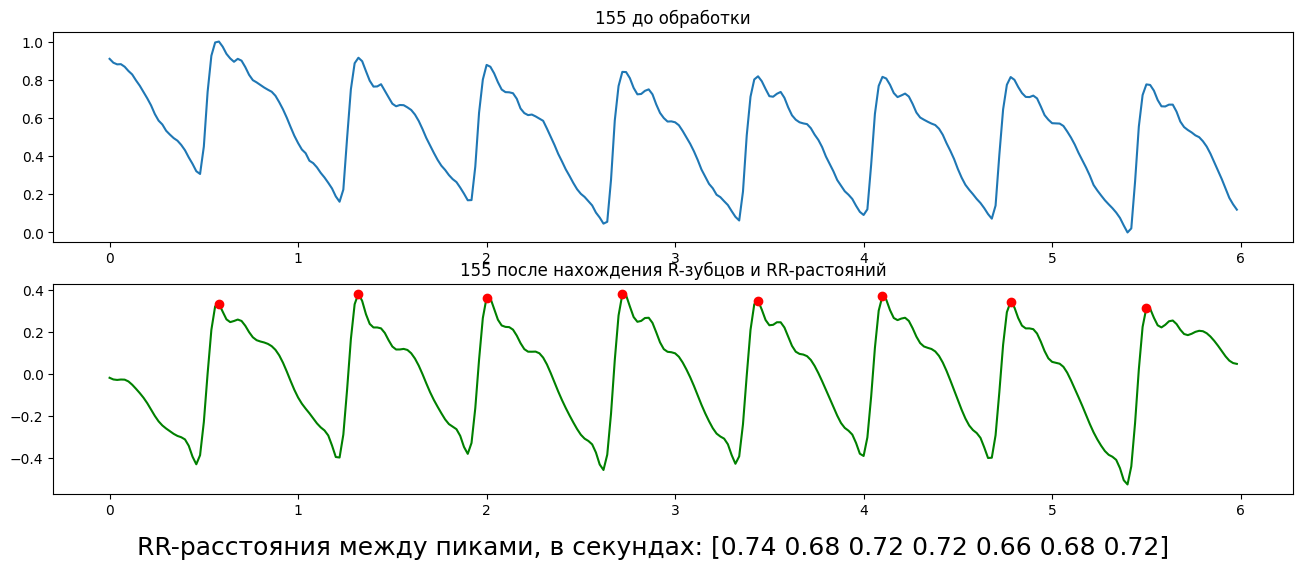

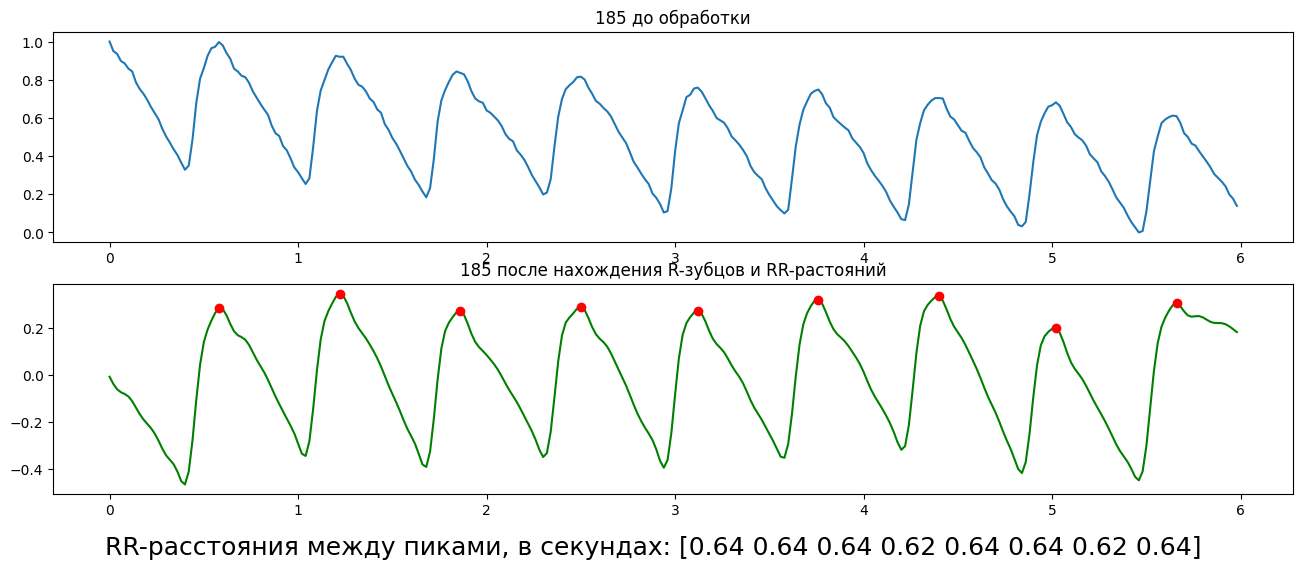

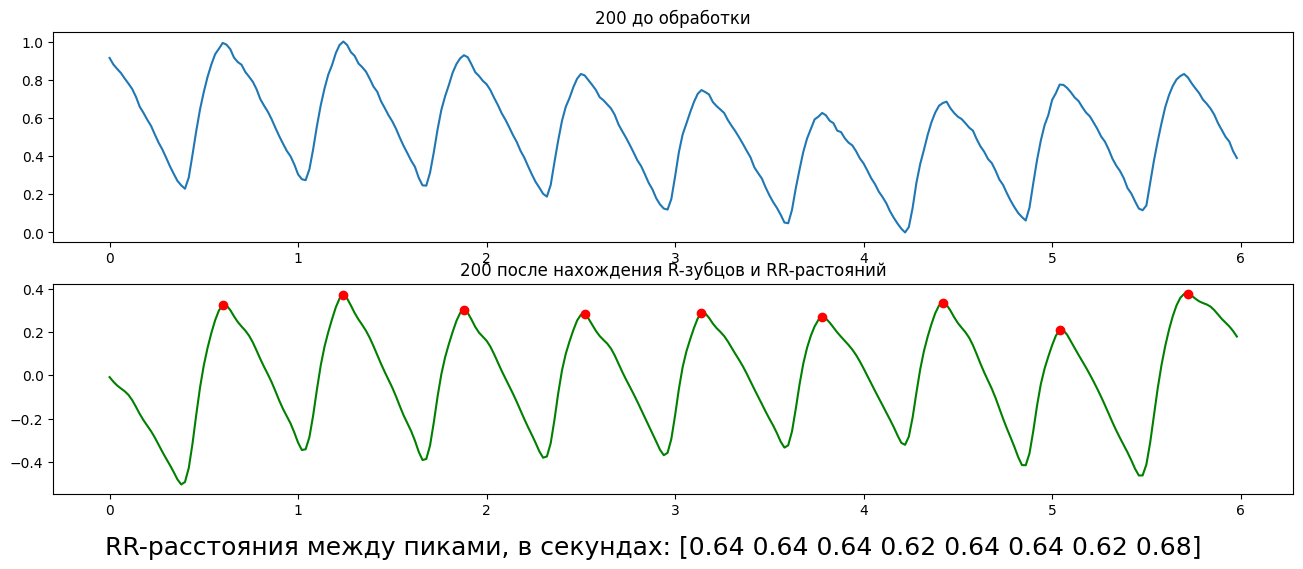

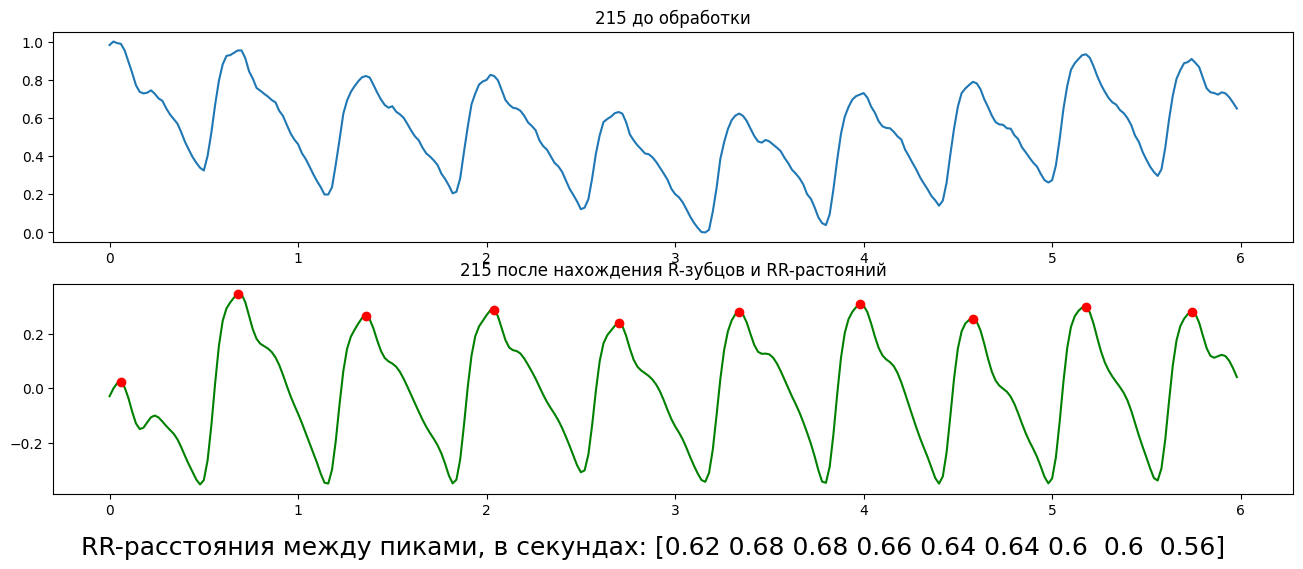

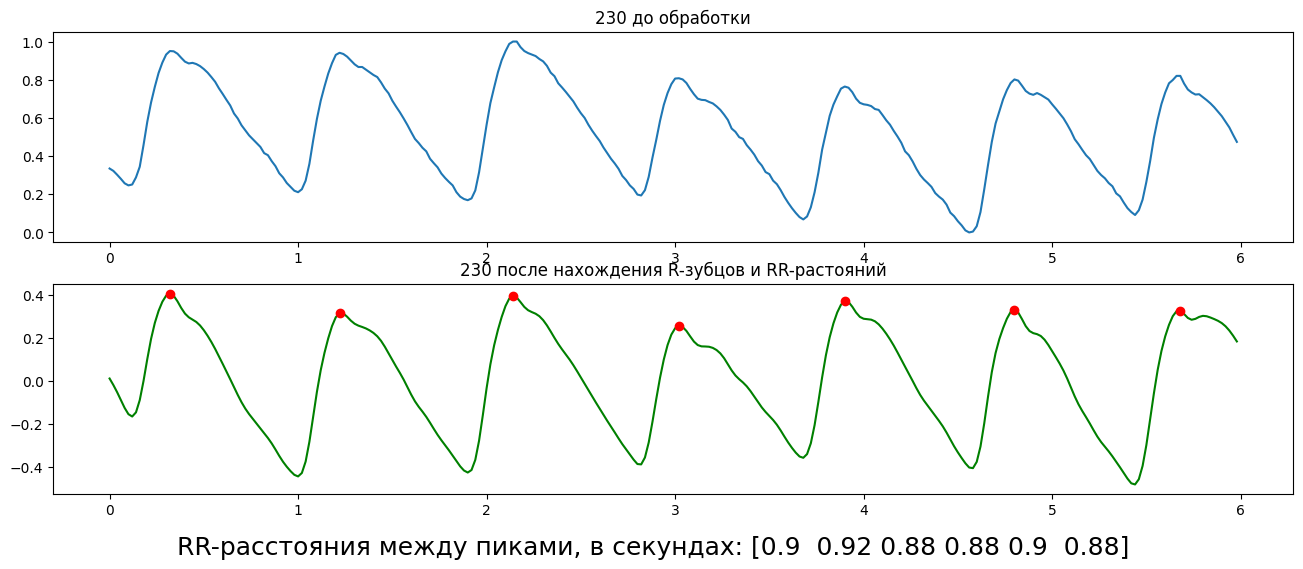

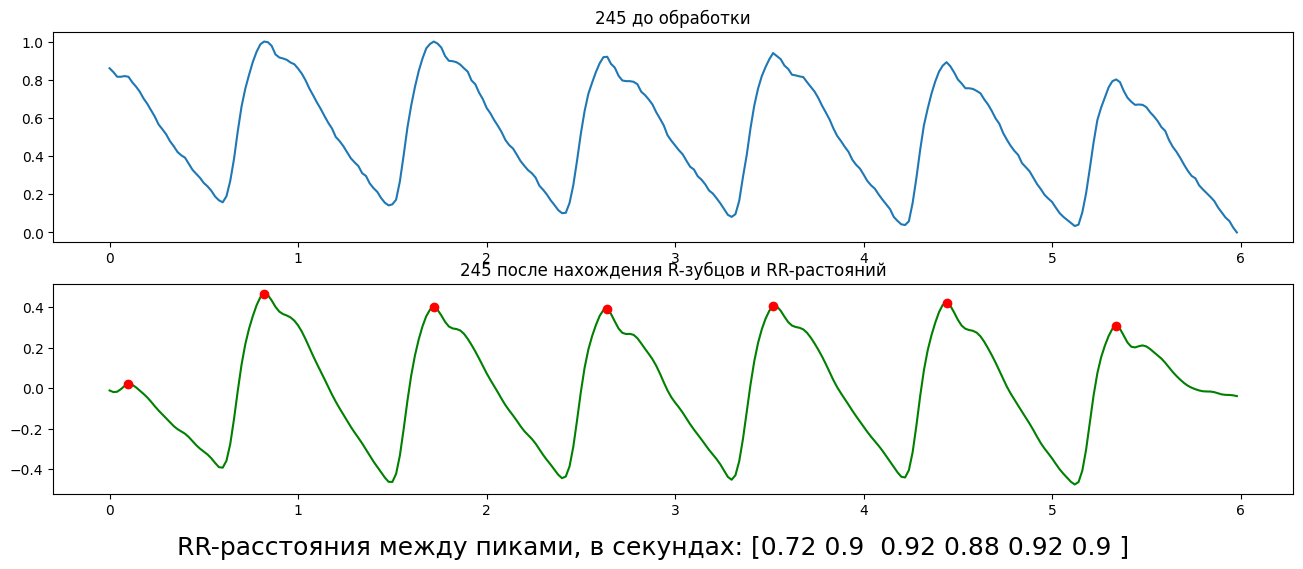

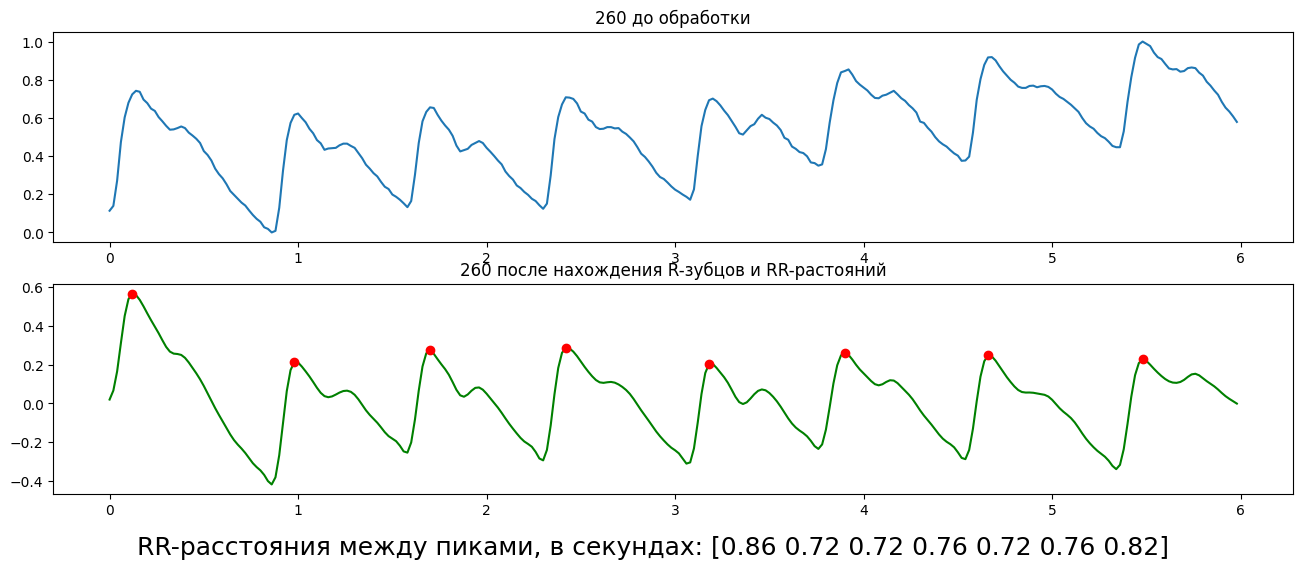

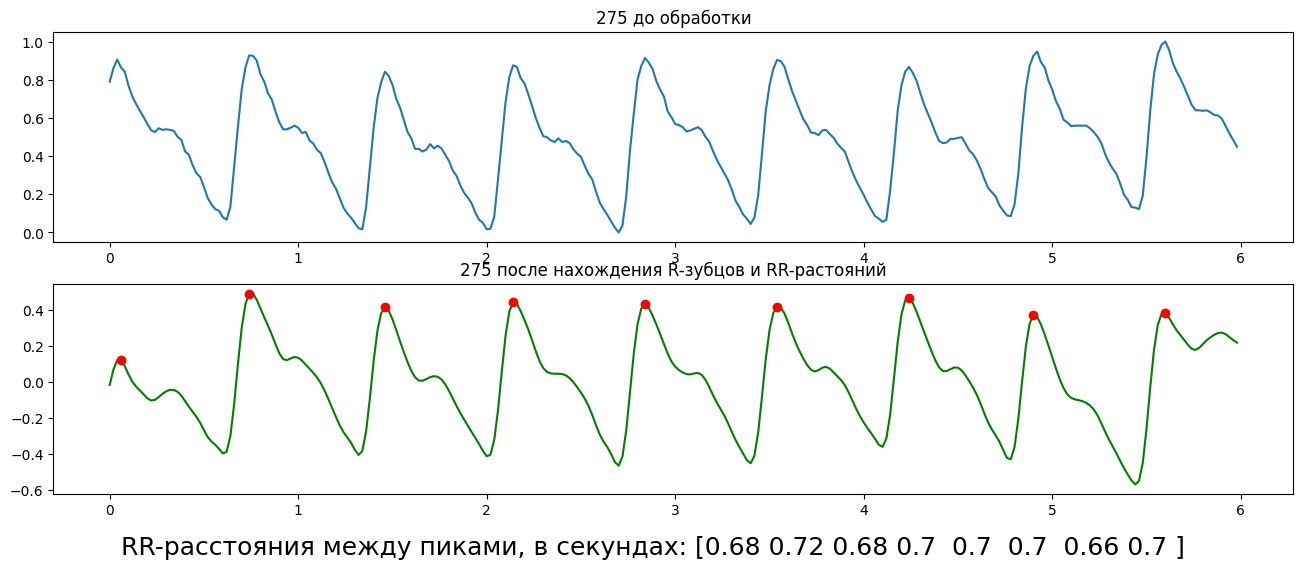

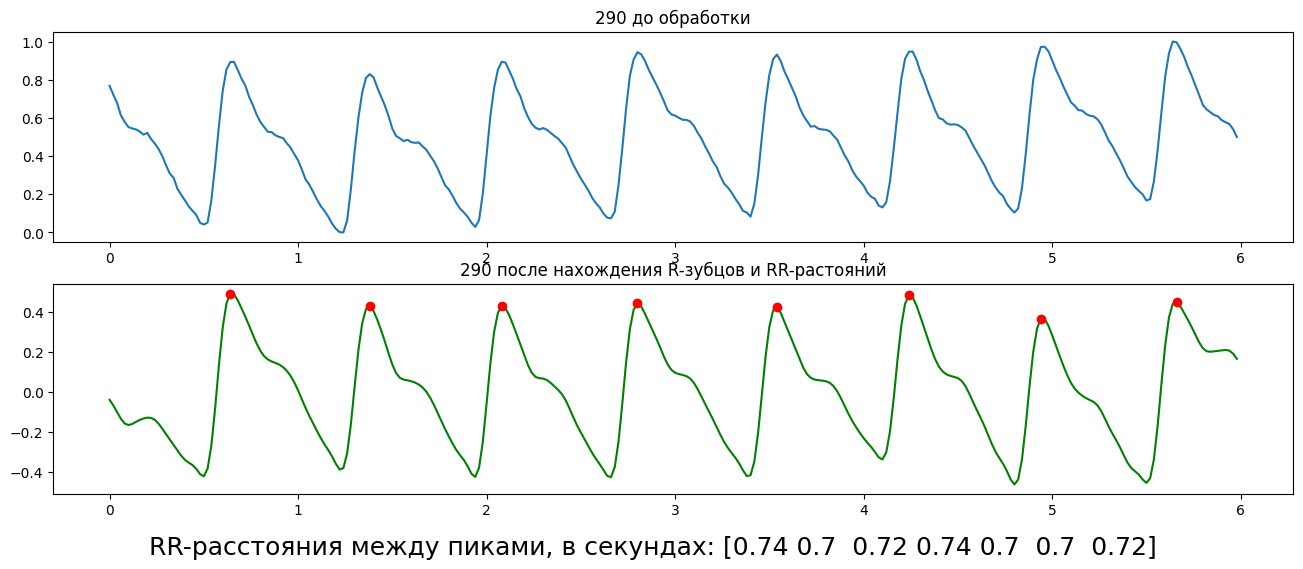

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def detect_r_peaks(ppg_signal, fs, lowcut=0.5, highcut=10.0):
    # Создаём и применяем полосовой фильтр
    b, a = butter_bandpass(lowcut, highcut, fs)
    filtered_signal = filtfilt(b, a, ppg_signal)

    peaks, _ = find_peaks(
        filtered_signal,
        distance=fs * 0.5,
        height=np.mean(filtered_signal)
    )
    
    return peaks, filtered_signal

def compute_rr_dist(r_peaks, fs):
    # Переводим расстояния сигнала в секунды
    rr_intervals = np.diff(r_peaks) / fs
    return rr_intervals


for i in range(5, 300, 15):
    example_signal = df[i][0:-2]

    r_peaks, filtered_signal = detect_r_peaks(example_signal, sample_rate)

    rr_dist = compute_rr_dist(r_peaks, sample_rate)

    plt.figure(figsize=(16, 12))

    plt.subplot(211)
    plt.title(f'{i} до обработки')
    plt.plot(time, example_signal)

    plt.subplot(212)
    plt.title(f'{i} после нахождения R-зубцов и RR-растояний')
    plt.plot(time, filtered_signal, color="green")
    plt.plot(r_peaks / sample_rate, filtered_signal[r_peaks], "ro")

    plt.figtext(0.5, 0.01, f'RR-расстояния между пиками, в секундах: {rr_dist}', ha="center", fontsize=18)
    plt.show()

Найдём другие параметры уже при помощи HeartPy

<Figure size 1600x600 with 0 Axes>

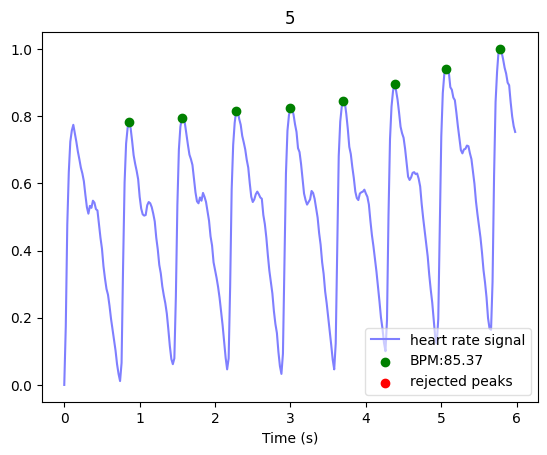

bpm: 85.365854
ibi: 702.857143
sdnn: 16.659863
sdsd: 13.743685
rmssd: 21.602469
pnn20: 0.166667
pnn50: 0.000000
hr_mad: 20.000000
sd1: 15.092309
sd2: 19.002924
s: 901.002455
sd1/sd2: 0.794210
breathingrate: 0.203252


<Figure size 1600x600 with 0 Axes>

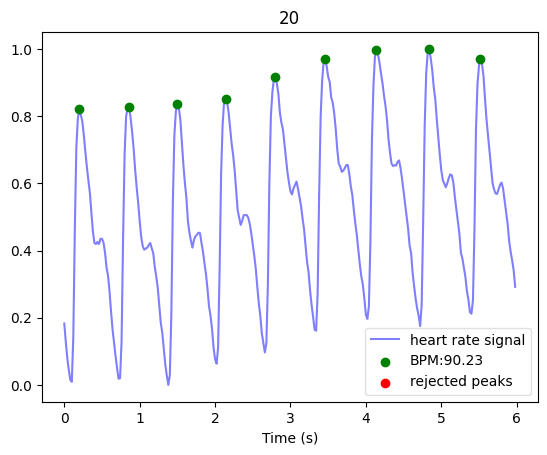

bpm: 90.225564
ibi: 665.000000
sdnn: 19.364917
sdsd: 9.035079
rmssd: 16.903085
pnn20: 0.000000
pnn50: 0.000000
hr_mad: 20.000000
sd1: 11.780302
sd2: 26.029810
s: 963.334892
sd1/sd2: 0.452570
breathingrate: 0.187970


<Figure size 1600x600 with 0 Axes>

bpm: 81.712062
ibi: 734.285714
sdnn: 38.119040
sdsd: 26.874192
rmssd: 50.990195
pnn20: 0.666667
pnn50: 0.500000
hr_mad: 20.000000
sd1: 34.075081
sd2: 34.075081
s: 3647.738137
sd1/sd2: 1.000000
breathingrate: 0.194553


<Figure size 1600x600 with 0 Axes>

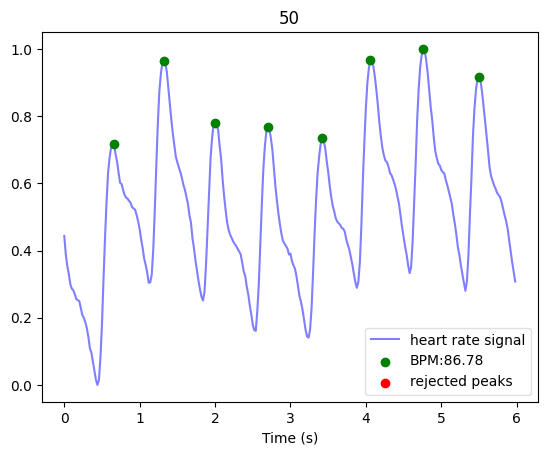

bpm: 86.776860
ibi: 691.428571
sdnn: 31.815796
sdsd: 23.094011
rmssd: 46.188022
pnn20: 0.500000
pnn50: 0.333333
hr_mad: 20.000000
sd1: 31.269438
sd2: 27.080128
s: 2660.239068
sd1/sd2: 1.154701
breathingrate: 0.206612


<Figure size 1600x600 with 0 Axes>

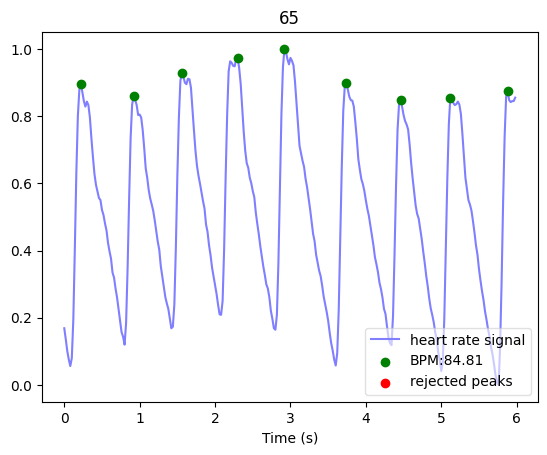

bpm: 84.805654
ibi: 707.500000
sdnn: 62.399920
sdsd: 43.705882
rmssd: 114.392807
pnn20: 1.000000
pnn50: 1.000000
hr_mad: 50.000000
sd1: 80.660538
sd2: 43.985155
s: 11145.950698
sd1/sd2: 1.833813
breathingrate: 0.176678


<Figure size 1600x600 with 0 Axes>

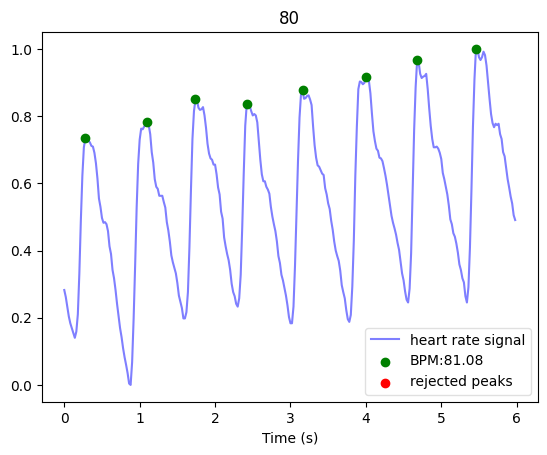

bpm: 81.081081
ibi: 740.000000
sdnn: 70.912421
sdsd: 49.888765
rmssd: 117.756812
pnn20: 1.000000
pnn50: 0.833333
hr_mad: 60.000000
sd1: 83.133093
sd2: 57.154761
s: 14927.126759
sd1/sd2: 1.454526
breathingrate: 0.193050


<Figure size 1600x600 with 0 Axes>

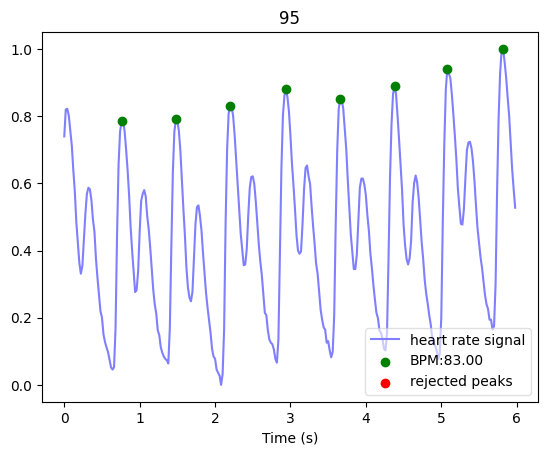

bpm: 83.003953
ibi: 722.857143
sdnn: 12.777531
sdsd: 13.743685
rmssd: 21.602469
pnn20: 0.166667
pnn50: 0.000000
hr_mad: 0.000000
sd1: 15.092309
sd2: 9.718253
s: 460.780145
sd1/sd2: 1.552986
breathingrate: 0.197628


<Figure size 1600x600 with 0 Axes>

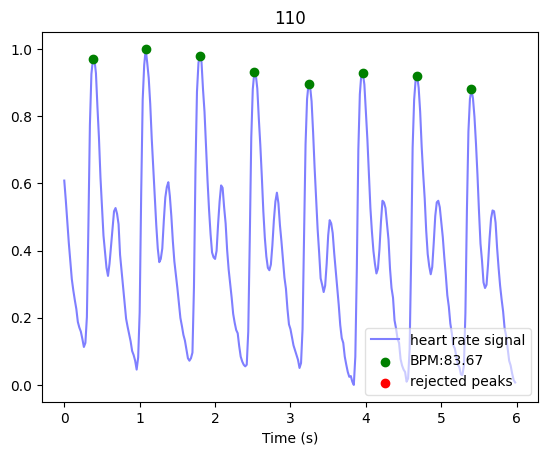

bpm: 83.665339
ibi: 717.142857
sdnn: 6.998542
sdsd: 7.453560
rmssd: 8.164966
pnn20: 0.000000
pnn50: 0.000000
hr_mad: 0.000000
sd1: 5.270463
sd2: 5.270463
s: 87.266463
sd1/sd2: 1.000000
breathingrate: 0.199203


<Figure size 1600x600 with 0 Axes>

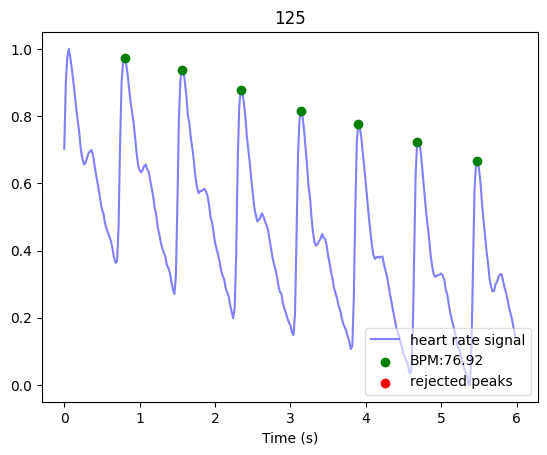

bpm: 76.923077
ibi: 780.000000
sdnn: 16.329932
sdsd: 8.000000
rmssd: 25.298221
pnn20: 0.200000
pnn50: 0.000000
hr_mad: 20.000000
sd1: 16.970563
sd2: 12.649111
s: 674.382214
sd1/sd2: 1.341641
breathingrate: 0.213675


<Figure size 1600x600 with 0 Axes>

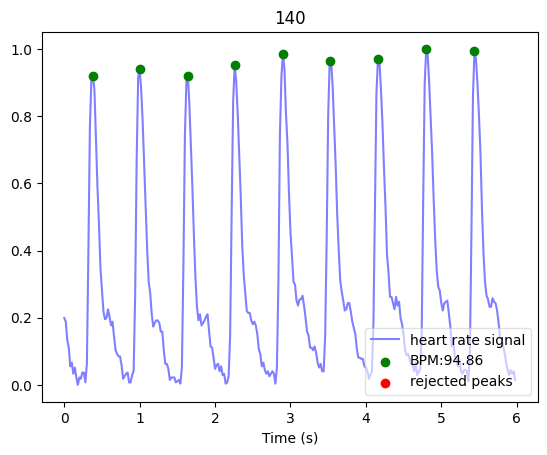

bpm: 94.861660
ibi: 632.500000
sdnn: 9.682458
sdsd: 9.035079
rmssd: 16.903085
pnn20: 0.000000
pnn50: 0.000000
hr_mad: 0.000000
sd1: 11.780302
sd2: 6.388766
s: 236.441250
sd1/sd2: 1.843909
breathingrate: 0.197628


<Figure size 1600x600 with 0 Axes>

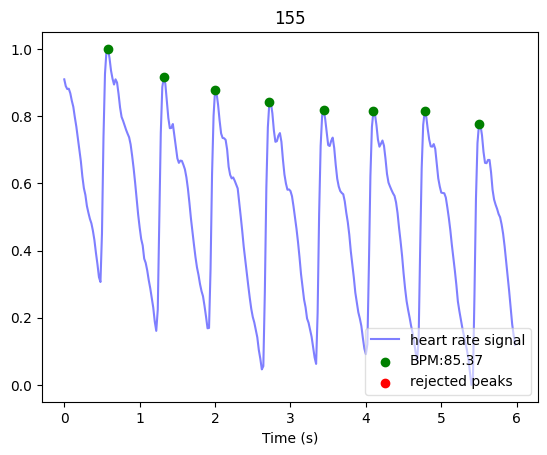

bpm: 85.365854
ibi: 702.857143
sdnn: 27.105237
sdsd: 21.343747
rmssd: 42.426407
pnn20: 0.666667
pnn50: 0.333333
hr_mad: 20.000000
sd1: 29.907264
sd2: 22.236107
s: 2089.225457
sd1/sd2: 1.344987
breathingrate: 0.203252


<Figure size 1600x600 with 0 Axes>

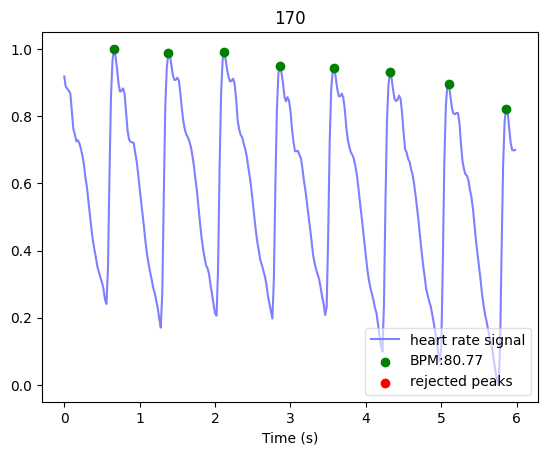

bpm: 80.769231
ibi: 742.857143
sdnn: 19.794866
sdsd: 11.547005
rmssd: 23.094011
pnn20: 0.166667
pnn50: 0.000000
hr_mad: 20.000000
sd1: 15.634719
sd2: 22.607767
s: 1110.446449
sd1/sd2: 0.691564
breathingrate: 0.192308


<Figure size 1600x600 with 0 Axes>

bpm: 94.861660
ibi: 632.500000
sdnn: 13.919411
sdsd: 6.998542
rmssd: 23.904572
pnn20: 0.142857
pnn50: 0.000000
hr_mad: 10.000000
sd1: 16.903085
sd2: 10.301575
s: 547.040502
sd1/sd2: 1.640825
breathingrate: 0.197628


<Figure size 1600x600 with 0 Axes>

bpm: 94.117647
ibi: 637.500000
sdnn: 18.540496
sdsd: 23.211538
rmssd: 34.641016
pnn20: 0.285714
pnn50: 0.285714
hr_mad: 10.000000
sd1: 24.411439
sd2: 10.301575
s: 790.036016
sd1/sd2: 2.369680
breathingrate: 0.196078


<Figure size 1600x600 with 0 Axes>

bpm: 94.861660
ibi: 632.500000
sdnn: 43.517238
sdsd: 20.603150
rmssd: 40.000000
pnn20: 0.428571
pnn50: 0.142857
hr_mad: 30.000000
sd1: 25.555063
sd2: 49.487166
s: 3973.007683
sd1/sd2: 0.516398
breathingrate: 0.197628


<Figure size 1600x600 with 0 Axes>

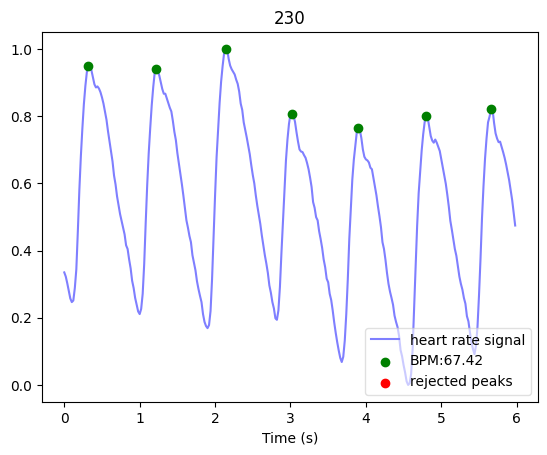

bpm: 67.415730
ibi: 890.000000
sdnn: 19.148542
sdsd: 14.966630
rmssd: 28.284271
pnn20: 0.400000
pnn50: 0.000000
hr_mad: 10.000000
sd1: 19.183326
sd2: 16.492423
s: 993.935572
sd1/sd2: 1.163160
breathingrate: 0.187266


<Figure size 1600x600 with 0 Axes>

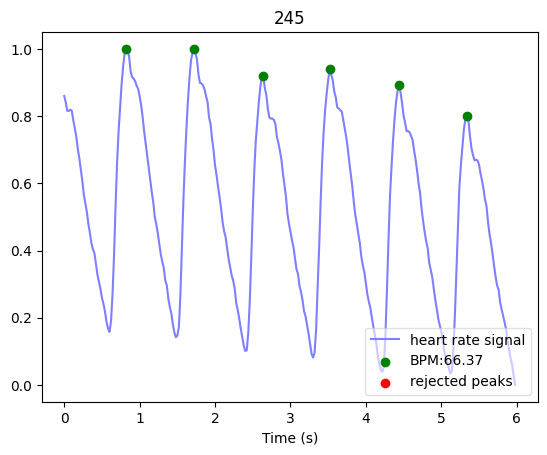

bpm: 66.371681
ibi: 904.000000
sdnn: 14.966630
sdsd: 10.000000
rmssd: 31.622777
pnn20: 0.500000
pnn50: 0.000000
hr_mad: 20.000000
sd1: 22.360680
sd2: 7.071068
s: 496.729413
sd1/sd2: 3.162278
breathingrate: 0.221239


<Figure size 1600x600 with 0 Axes>

bpm: 80.357143
ibi: 746.666667
sdnn: 35.901099
sdsd: 14.966630
rmssd: 46.475800
pnn20: 0.800000
pnn50: 0.400000
hr_mad: 30.000000
sd1: 29.664794
sd2: 31.749016
s: 2958.839956
sd1/sd2: 0.934353
breathingrate: 0.223214


<Figure size 1600x600 with 0 Axes>

bpm: 86.419753
ibi: 694.285714
sdnn: 13.997084
sdsd: 14.907120
rmssd: 20.000000
pnn20: 0.166667
pnn50: 0.000000
hr_mad: 20.000000
sd1: 13.333333
sd2: 10.540926
s: 441.537256
sd1/sd2: 1.264911
breathingrate: 0.205761


<Figure size 1600x600 with 0 Axes>

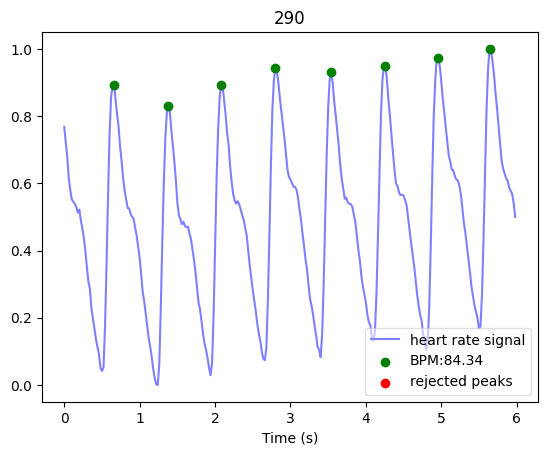

bpm: 84.337349
ibi: 711.428571
sdnn: 18.070158
sdsd: 0.000000
rmssd: 20.000000
pnn20: 0.000000
pnn50: 0.000000
hr_mad: 20.000000
sd1: 13.333333
sd2: 19.436506
s: 814.154473
sd1/sd2: 0.685994
breathingrate: 0.200803


In [49]:
for i in range(5, 300, 15):
    wd, m = hp.process(df[i][0:-2], sample_rate=sample_rate)
    
    plt.figure(figsize=(16, 6))
    hp.plotter(wd, m)
    plt.title(i)
    plt.show()

    for measure in m.keys():
        print('%s: %f' %(measure, m[measure]))